In [1]:
import geopandas as gpd
import osmnx as ox
from shapely import geometry
from quetzal.model import stepmodel
from syspy.spatial.graph.graphbuilder import OsmnxCleaner

In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none func

# Preparation of the transport network.
## Saves road infrastructure built with OSMNX
Needs StepModel with zones

In [2]:
input_path = '../input_static/'
output_path = '../output/'
model_path = '../model/'

In [3]:
# Loading StepModel with zones
sm = stepmodel.read_json(model_path + 'de_zones')

In [4]:
sm.zones = gpd.GeoDataFrame(sm.zones)
sm.zones.head(3)

,CNTR_CODE,LEVL_CODE,NUTS_ID,population,area,urbanisation,lau_id,geometry
index,,,,,,,,
DE600,DE,3,DE600,1841179,755.09,1.0,2000,"MULTIPOLYGON (((9.94538 53.65293, 9.95059 53.6..."
DE711,DE,3,DE711,159207,122.07,1.0,6411,"POLYGON ((8.72571 49.95421, 8.73453 49.94858, ..."
DE712,DE,3,DE712,753056,248.31,1.0,6412,"POLYGON ((8.59024 50.15954, 8.58867 50.16843, ..."


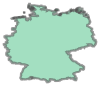

In [5]:
# Get the reference geometric hull
sm.hull = sm.zones["geometry"].buffer(1e-3).unary_union
sm.hull

### Create a road network

In [6]:
# Download filtered network from OpenStreetMap
#custom_filter = '["area"!~"yes"]["highway"!~"tertiary|living_street|residential|cycleway|footway|path|pedestrian|steps|track|corridor|elevator|escalator|proposed|construction|bridleway|abandoned|platform|raceway|service|bus_stop|no|razed|emergency_bay|rest_area|planned|escape|turning_circle|access_ramp|disused"]["motor_vehicle"!~"no"]["motorcar"!~"no"]["access"!~"private"]["service"!~"parking|parking_aisle|driveway|private|emergency_access"]'
custom_filter = '["area"!~"yes"]["highway"~"motorway|primary|secondary|trunk|motorway_link|primary_link|secondary_link|trunk_link"]["motor_vehicle"!~"no"]["motorcar"!~"no"]["access"!~"private"]["service"!~"parking|parking_aisle|driveway|private|emergency_access"]'
G = ox.graph_from_polygon(sm.hull, simplify=True, custom_filter=custom_filter)

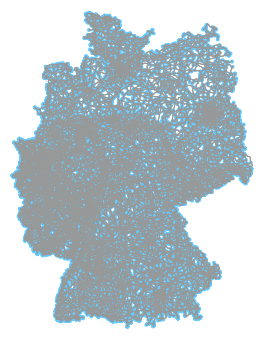

(<Figure size 527.865x432 with 1 Axes>, <AxesSubplot:>)

In [7]:
# Show the network graph
ox.plot_graph(G)

In [8]:
# Get Geodataframes
road_nodes, road_links = ox.graph_to_gdfs(G)
print(road_nodes.columns)
print(road_links.columns)

Index(['y', 'x', 'osmid', 'highway', 'ref', 'geometry'], dtype='object')
Index(['u', 'v', 'key', 'osmid', 'oneway', 'lanes', 'name', 'highway',
       'maxspeed', 'length', 'geometry', 'ref', 'bridge', 'junction', 'width',
       'tunnel', 'access', 'landuse', 'area', 'est_width', 'service'],
      dtype='object')


In [9]:
road_nodes['osmid'] = road_nodes['osmid'].astype(str)
road_nodes = road_nodes.set_index('osmid')[['geometry']]
road_links[['u', 'v']] = road_links[['u', 'v']].astype(str)
road_links['highway'] = road_links['highway'].astype(str)

In [10]:
# reduces links to their start and end point
def simplify_link(g):
    l = list(g.coords)
    return geometry.LineString([l[0], l[-1]])
road_links['geometry'] = road_links['geometry'].apply(simplify_link)

In [11]:
# Apply the quetzal road network cleaner
cleaner = OsmnxCleaner(
    road_links, 
    road_nodes, 
    a='u', 
    b='v')
cleaner.add_reversed_links(
    direction_column='oneway', 
    reverse_value=False)
cleaner.clean_geometries()
cleaner.fix_nodeset_consistency()

In [32]:
# Add road links to the stepmodel
sm.road_links = cleaner.links[['a', 'b', 'length', 'geometry', 'highway', 'maxspeed', 'lanes']]
sm.road_links['id'] = ['rl_' + str(ind) for ind in sm.road_links.index]
sm.road_links.set_index('id', drop=True, inplace=True)
sm.road_links.head()

,a,b,length,geometry,highway,maxspeed,lanes
id,,,,,,,
rl_1,150994944,25180712,439.598,"LINESTRING (7.81243 48.01845, 7.80915 48.01517)",trunk,80,"[2, 3]"
rl_2,524303,1596078850,3055.094,"LINESTRING (8.44804 49.93936, 8.41683 49.95807)",secondary,"[70, 50]",NaN
rl_3,524303,524306,392.974,"LINESTRING (8.44804 49.93936, 8.45207 49.93696)",secondary,50,2
rl_4,524303,31403021,3557.277,"LINESTRING (8.44804 49.93936, 8.40959 49.92418)",secondary,"[70, 30]",NaN
rl_5,59768848,2083991773,55.757,"LINESTRING (13.04162 48.76792, 13.04130 48.76838)",primary,70,2


In [13]:
# Add road nodes to the stepmodel
sm.road_nodes = cleaner.nodes[['geometry']]
sm.road_nodes.head()

,geometry
osmid,
5125955591,POINT (12.50832 51.13886)
27000880,POINT (7.02550 50.58543)
205403679,POINT (8.14727 51.25863)
273142630,POINT (9.71858 48.45182)
2749374176,POINT (12.63433 54.05378)


In [14]:
len(sm.road_links.index)

489649

In [15]:
len(sm.road_nodes.index)

172538

In [33]:
# Fix the network integrity
sm.integrity_fix_collision()
sm.integrity_fix_road_network(cutoff=10, recursive_depth=5)
sm.integrity_fix_road_nodeset_consistency()

direct: 172538it [01:39, 1726.13it/s]
reversed: 172538it [01:39, 1739.11it/s]
162487it [01:39, 1627.28it/s]


In [34]:
# Check the road network integrity
sm.integrity_test_road_network(cutoff=10)
print(sm.missing_road_nodes)

162487it [01:31, 1768.37it/s]


set()


### Save road network

In [35]:
# Make links table smaller
sm.road_links['length'] = sm.road_links['length'].astype(int)

In [18]:
# Split road links in graph and auxiliary information
# for file sizes being compatible with github's size limit
cols = ['highway', 'length', 'maxspeed', 'lanes']
auxiliary = sm.road_links[cols]
sm.road_links.drop(cols, axis=1, inplace=True)

In [40]:
sm.to_json(input_path + 'de_road_network', only_attributes=[
    'road_links', 'road_nodes', 'zones'], encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 36/36 [03:01<00:00,  5.03s/it]


In [23]:
# Save auxiliary information seperately
auxiliary['index'] = auxiliary.index
auxiliary.reset_index(drop=True, inplace=True)
auxiliary.to_json(input_path + 'de_road_network/road_links_quetzaldata.json')